In [8]:
import random
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

class GeometricBrownianMotionAssetSimulator:
    def __init__(
        self,
        start_date,
        end_date,
        symbol_length=5,
        price_range=(100, 100),
        mu=0.1,
        sigma=0.3,
        pareto_shape=1.5
    ):
        self.start_date = start_date
        self.end_date = end_date
        self.symbol_length = symbol_length
        self.price_range = price_range
        self.mu = mu
        self.sigma = sigma
        self.pareto_shape = pareto_shape

    def _generate_random_symbol(self):
        return ''.join(random.choices(string.ascii_uppercase, k=self.symbol_length))

    def _generate_random_price(self):
        return random.uniform(self.price_range[0], self.price_range[1])

    def _create_empty_frame(self):
        date_range = pd.date_range(self.start_date, self.end_date, freq='B')
        zeros = pd.Series(np.zeros(len(date_range)))
        return pd.DataFrame({
            'date': date_range,
            'open': zeros,
            'high': zeros,
            'low': zeros,
            'close': zeros,
            'volume': zeros
        })[['date', 'open', 'high', 'low', 'close', 'volume']]

    def _create_geometric_brownian_motion(self, data, init_price):
        n = len(data)
        T = n / 252.0
        dt = T / (4.0 * n)
        asset_path = np.exp(
            (self.mu - self.sigma**2 / 2) * dt +
            self.sigma * np.random.normal(0, np.sqrt(dt), size=(4 * n))
        )
        return init_price * asset_path.cumprod()

    def _append_path_to_data(self, data, path):
        data['open'] = path[0::4]
        data['close'] = path[3::4]
        data['high'] = np.maximum(
            np.maximum(path[0::4], path[1::4]),
            np.maximum(path[2::4], path[3::4])
        )
        data['low'] = np.minimum(
            np.minimum(path[0::4], path[1::4]),
            np.minimum(path[2::4], path[3::4])
        )

    def _append_volume_to_data(self, data):
        data['volume'] = np.array(list(map(
            int,
            np.random.pareto(self.pareto_shape, size=len(data)) * 1000000.0
        )))

    def generate(self, num_assets=1, random_seed=42):
        random.seed(random_seed)
        np.random.seed(random_seed)
        
        dfs = []
        for i in range(num_assets):
            symbol = self._generate_random_symbol()
            data = self._create_empty_frame()
            init_price = self._generate_random_price()
            path = self._create_geometric_brownian_motion(data, init_price)
            self._append_path_to_data(data, path)
            self._append_volume_to_data(data)
            data['symbol'] = symbol
            dfs.append(data)
            
        return pd.concat(dfs)

In [9]:
def plot_all_stocks(df):
    symbols = df['symbol'].unique()
    n = len(symbols)
    cols = 5
    rows = math.ceil(n/cols)
    
    fig, axs = plt.subplots(rows, cols, figsize=(20, 4*rows))
    axs = axs.ravel()
    
    for idx, symbol in enumerate(symbols):
        data = df[df['symbol'] == symbol]
        axs[idx].plot(pd.to_datetime(data['date']), data['close'])
        axs[idx].set_title(f"{symbol} (Start: {data['open'].iloc[0]:.2f})")
        axs[idx].tick_params(axis='x', rotation=45)
    
    for idx in range(n, len(axs)):
        axs[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [10]:
simulator = GeometricBrownianMotionAssetSimulator(
    start_date='2020-01-01',
    end_date='2025-02-01',
    price_range=(20.0, 500.0),
    mu=0,
    sigma=0.6
)

df = simulator.generate(num_assets=100)

In [11]:
df.to_parquet('../../data/raw/sim_daily.parquet')

# Plots

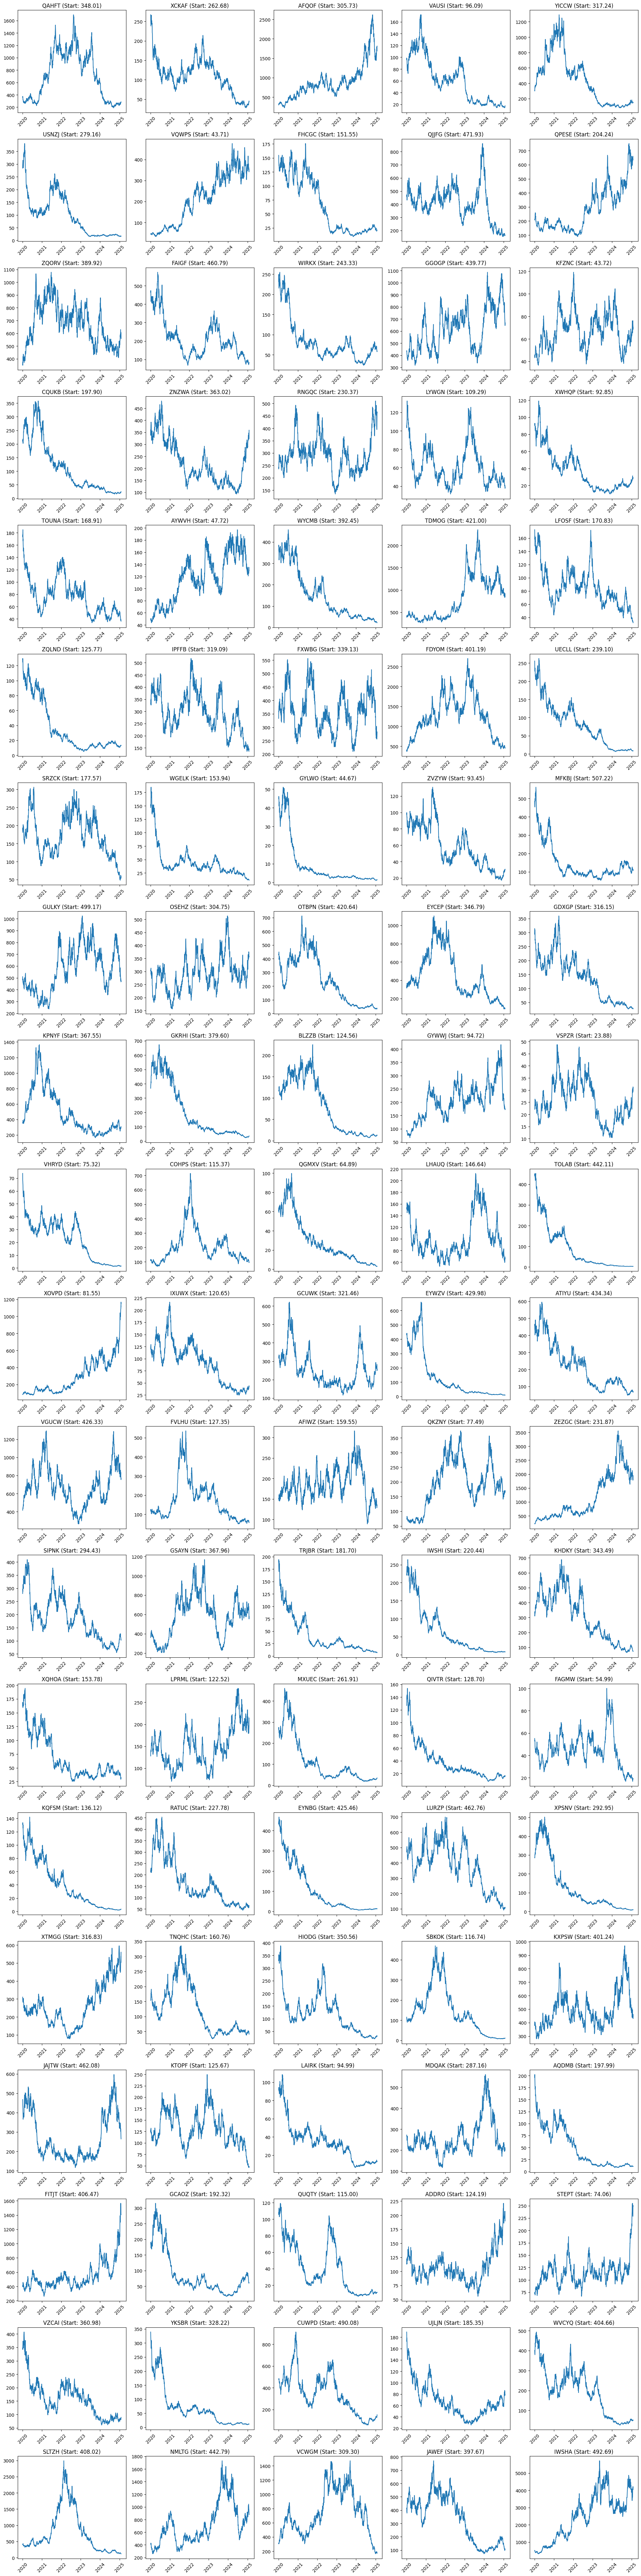

/var/folders/lm/w5v6vwl91955r0nc47_mqt88flhqcv/T/ipykernel_62655/3256543571.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


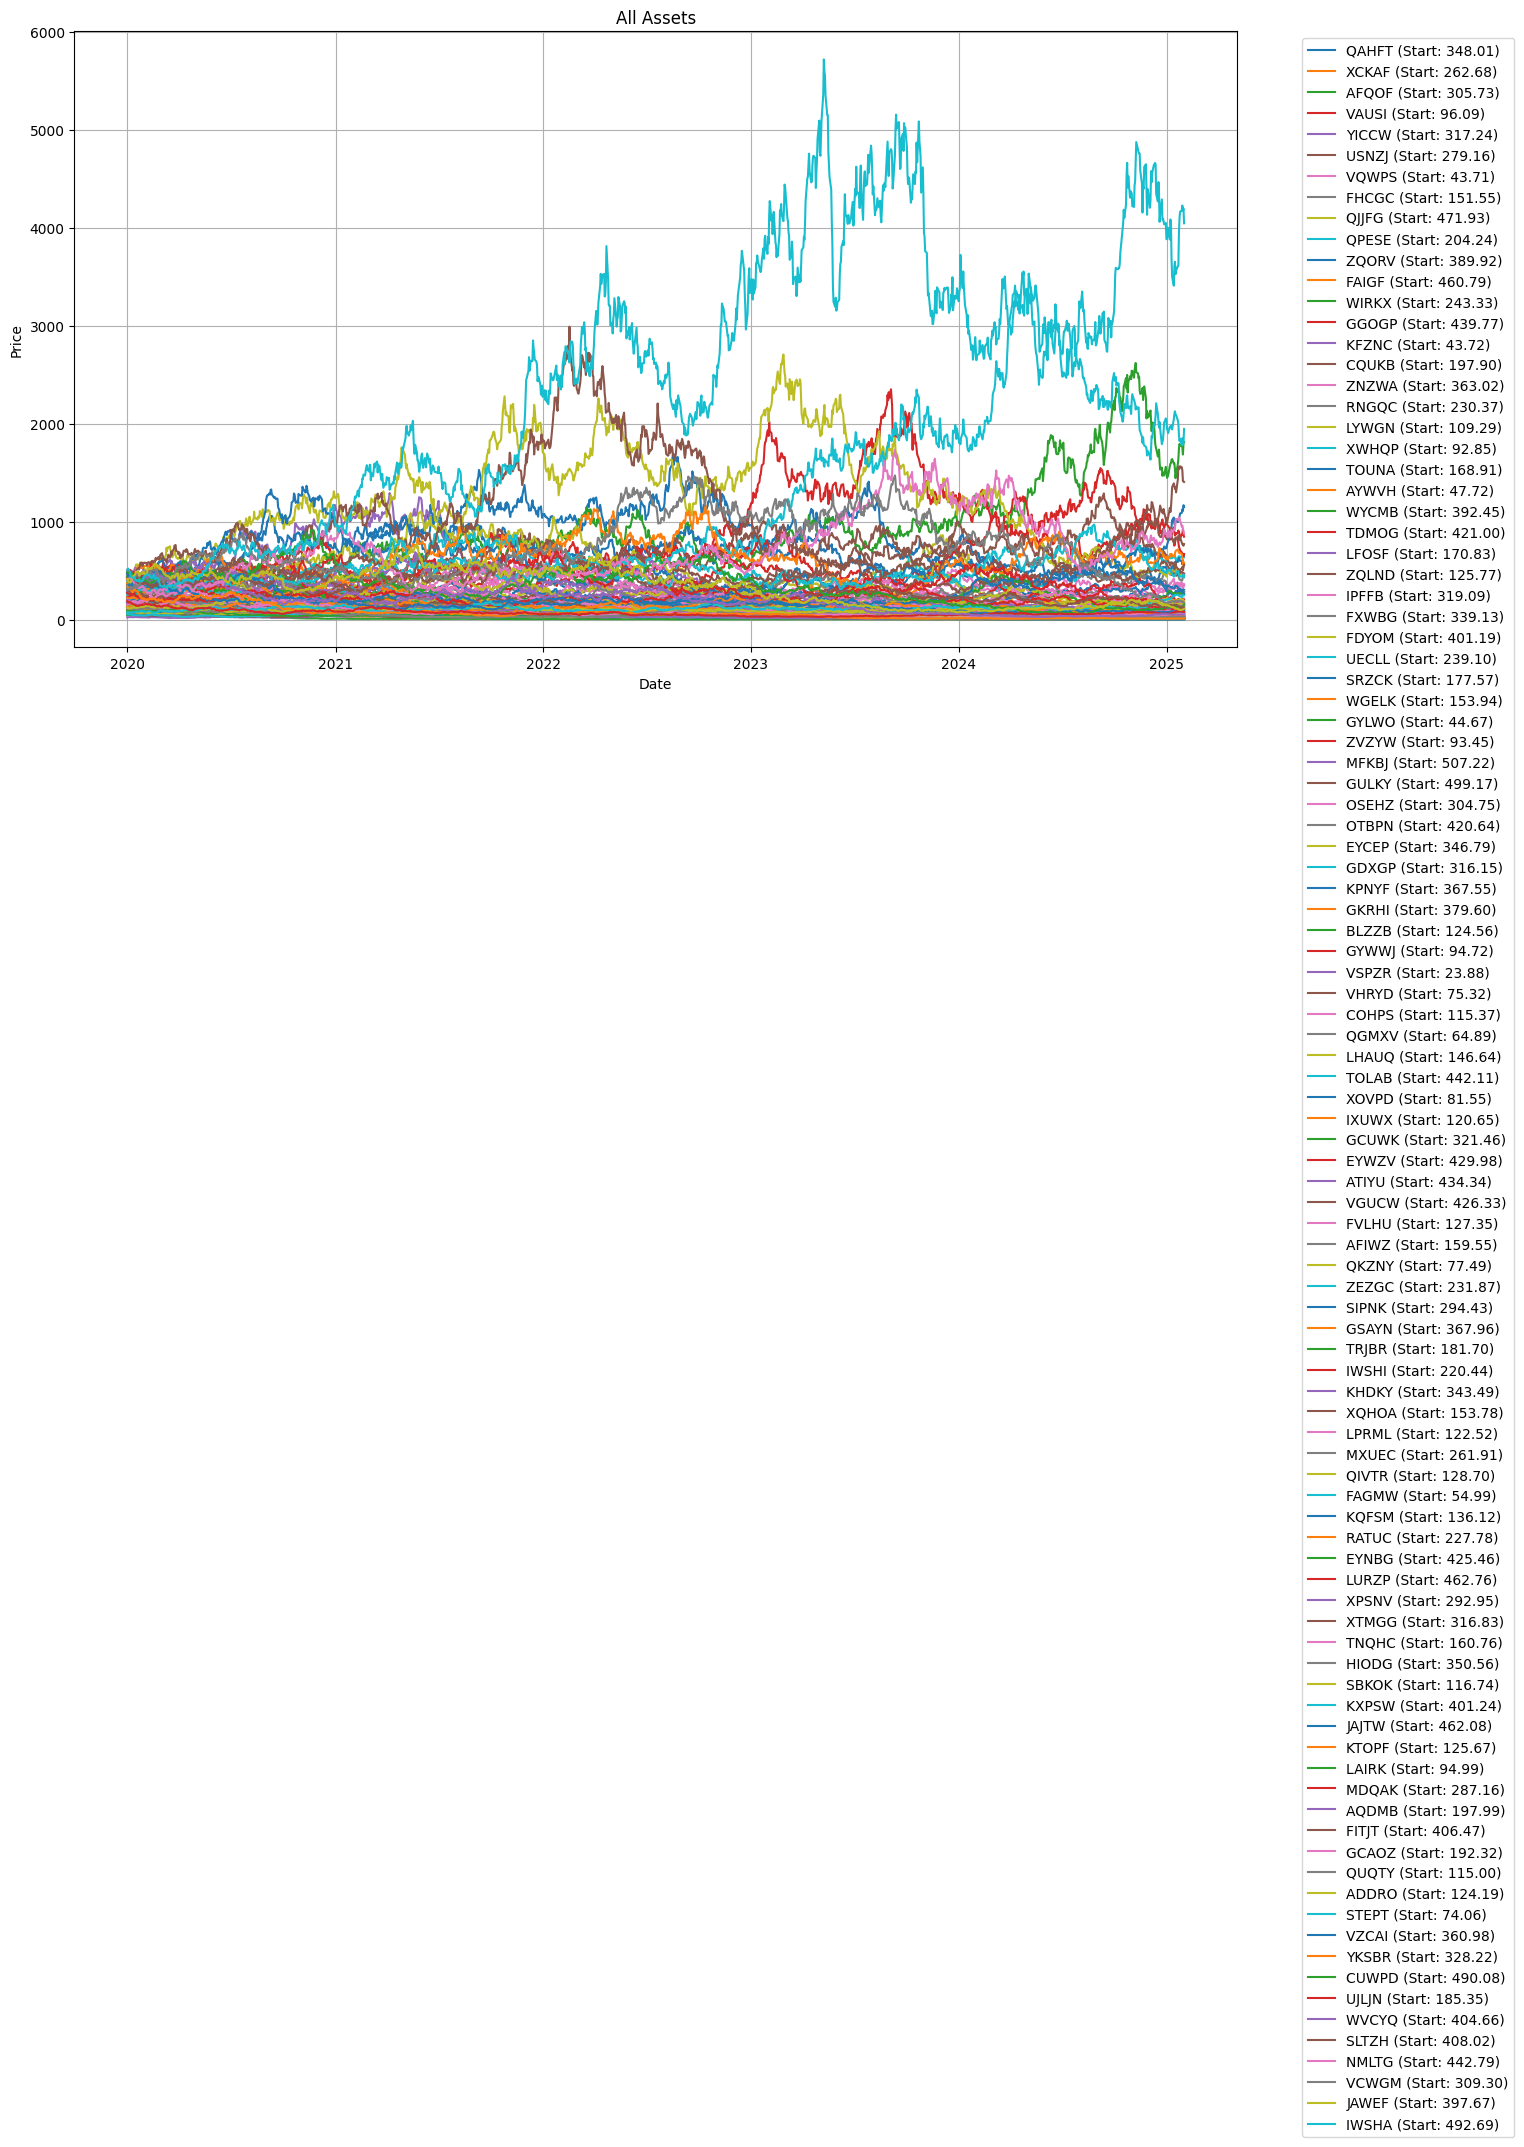

In [12]:

plot_all_stocks(df)

plt.figure(figsize=(15,8))
for symbol in df['symbol'].unique():
    data = df[df['symbol'] == symbol]
    plt.plot(data['date'], data['close'], label=f"{symbol} (Start: {data['open'].iloc[0]:.2f})")

plt.title('All Assets')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

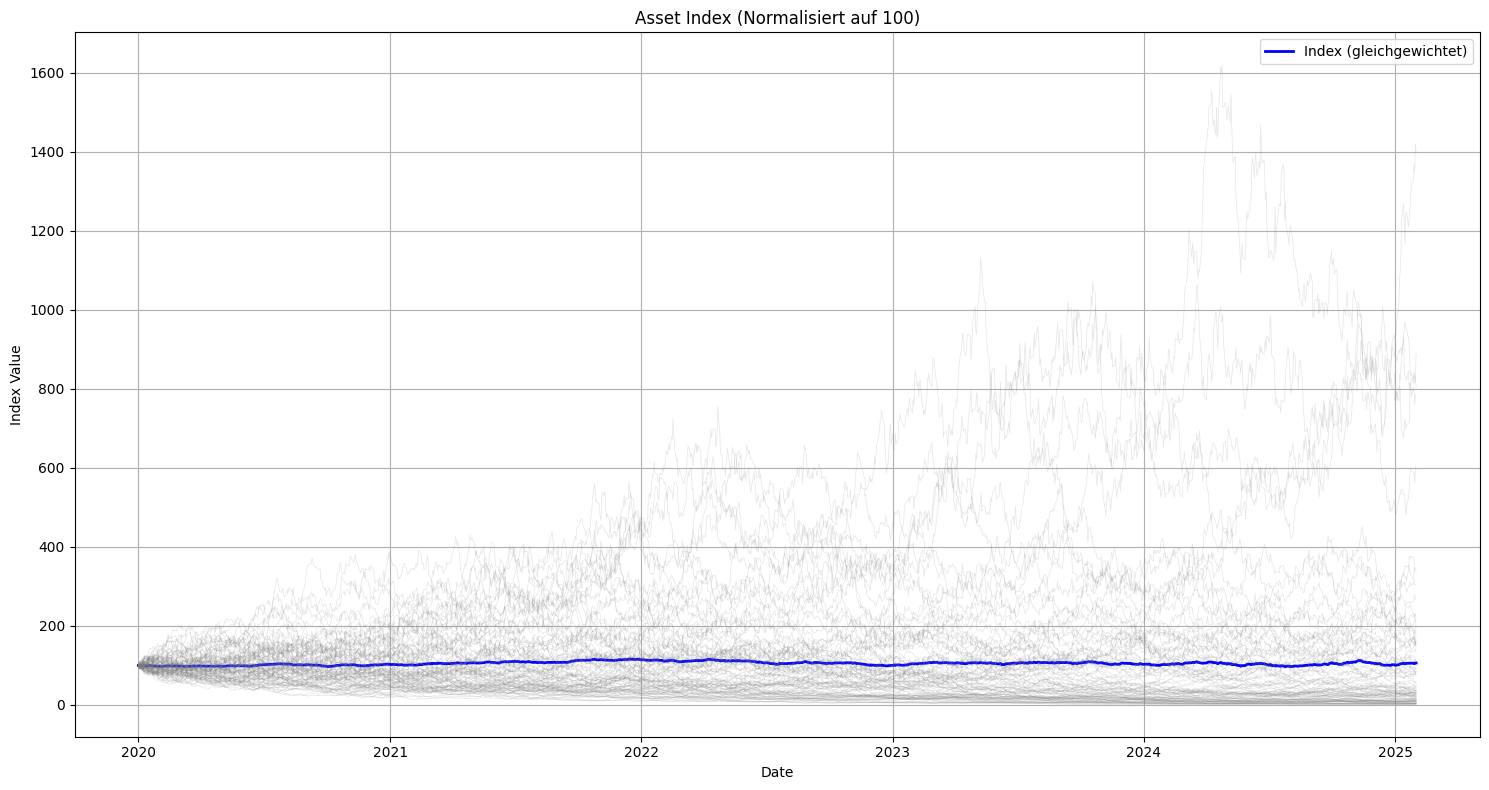

In [13]:
def plot_index(df):
    plt.figure(figsize=(15,8))
    
    normalized_df = df.copy()
    for symbol in df['symbol'].unique():
        mask = df['symbol'] == symbol
        start_price = df[mask]['close'].iloc[0]
        normalized_df.loc[mask, 'close'] = df[mask]['close'] / start_price * 100

    index_values = normalized_df.groupby('date')['close'].mean()
    
    plt.plot(index_values.index, index_values.values, 'b-', linewidth=2, label='Index (gleichgewichtet)')
    
    for symbol in df['symbol'].unique():
        mask = normalized_df['symbol'] == symbol
        plt.plot(normalized_df[mask]['date'], 
                normalized_df[mask]['close'], 
                'gray', alpha=0.2, linewidth=0.5)
    
    plt.title('Asset Index (Normalisiert auf 100)')
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_index(df)

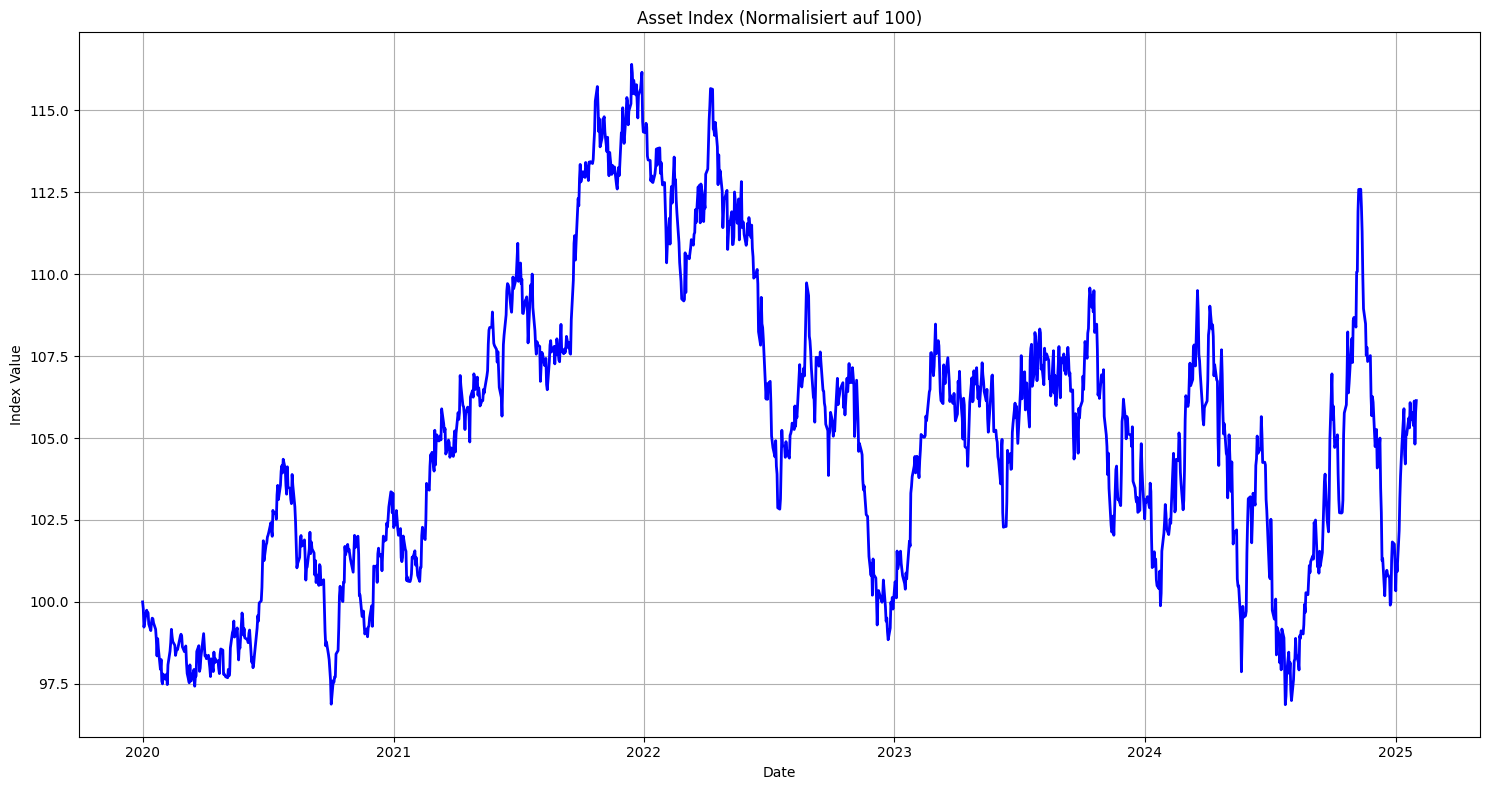

In [14]:
def plot_pure_index(df):
    plt.figure(figsize=(15,8))
    
    normalized_df = df.copy()
    for symbol in df['symbol'].unique():
        mask = df['symbol'] == symbol
        start_price = df[mask]['close'].iloc[0]
        normalized_df.loc[mask, 'close'] = df[mask]['close'] / start_price * 100

    index_values = normalized_df.groupby('date')['close'].mean()
    
    plt.plot(index_values.index, index_values.values, 'b-', linewidth=2)
    
    plt.title('Asset Index (Normalisiert auf 100)')
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pure_index(df)